# LSTM

In [14]:


import math
import matplotlib
import numpy as np
import pandas as pd
import pydot as pyd
import time
import tensorflow as tf
import keras

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import notebook
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

#### Input params ##################
stk_path = "./VTI.csv"
test_size = 0.2                # процент датасета для тренировочных данных
cv_size = 0.2                  # процент данных для кросс валидации

N = 9                          # число предыдуших дней (для рассчета стоимости)
                               
                               # Параметры LSTM 
lstm_units=50                  # размерность нейронной сети
dropout_prob=0.5               # исключение определённого процента случайных нейронов
optimizer='adam'               # алгоритм оптимизации адаптивной скорости обучения, разработанный специально для обучения глубоких нейронных сетей
epochs=1                       # число итераций в процессе обучения
batch_size=10                   # Общее число тренировочных объектов, представленных в одном батче.

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
tf.random.set_seed(100)
# проблема с либой
keras.utils.vis_utils.pydot = pyd


In [15]:
def get_mape(y_true, y_pred): 
    """
    Вычисляем среднюю абсолютную процентную ошибку (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Разделяем данные
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    return x, y

def train_pred_eval_model(x_train_scaled, 
                          y_train_scaled,
                          x_cv_scaled,
                          y_cv_scaled,
                          scaler,
                          lstm_units=lstm_units,
                          dropout_prob=dropout_prob,
                          optimizer=optimizer,
                          epochs=epochs,
                          batch_size=batch_size):
    '''
        x_train_scaled: например, x_train_scaled.shape = (451, 9, 1). Здесь мы используем последние 9 значений, чтобы предсказать следующее значение
         y_train_scaled: например, y_train_scaled.shape = (451, 1)
         x_cv_scaled: используйте это, чтобы делать прогнозы
         y_cv_scaled: фактическое значение прогнозов
         Scaler: scaler, который используется для fit_transform тренировочного набора
     Output
         rmse: среднеквадратическая ошибка
         mape: средняя абсолютная ошибка в процентах
         оценка: предсказания
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    # сколько выдает слоев
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    est_scaled = model.predict(x_cv_scaled)
    est = scaler.inverse_transform(est_scaled)
    
    y_cv = scaler.inverse_transform(y_cv_scaled)

    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# Load data

In [16]:
data = pd.read_csv(stk_path, sep = ",")

# Date -> datetime
data.loc[:, 'Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

# Нормализуем названия
data.columns = [str(x).lower().replace(' ', '_') for x in data.columns]

# Номер месяца каждого примера
data['month'] = data['date'].dt.month

# Сортируем
data.sort_values(by='date', inplace=True, ascending=True)

data.head()

,date,open,high,low,close,adj_close,volume,month
0,2019-12-26,163.699997,164.229996,163.630005,164.229996,161.357681,2515000,12
1,2019-12-27,164.610001,164.679993,163.800003,164.080002,161.210297,2356700,12
2,2019-12-30,164.300003,164.380005,162.910004,163.190002,160.335861,4503500,12
3,2019-12-31,163.000000,163.759995,162.720001,163.619995,160.758331,3262400,12
4,2020-01-02,164.679993,164.979996,163.779999,164.979996,162.094574,3291100,1


Text(0, 0.5, 'USD')

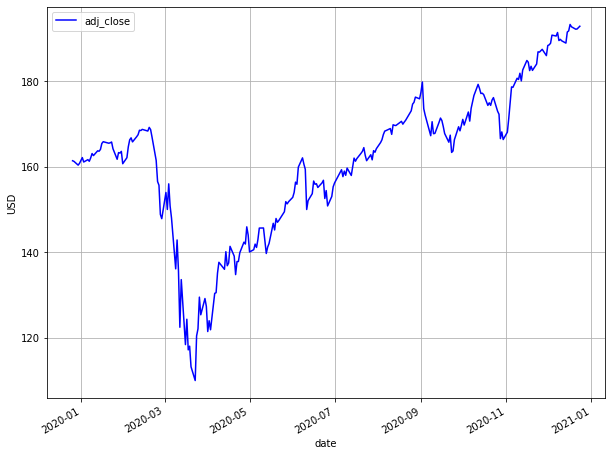

In [17]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = data.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test sets

In [18]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(data))
num_test = int(test_size*len(data))
num_train = len(data) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Делим датасет на кросс валидацию и тренировочные
train = data[:num_train][['date', 'adj_close']]
cv = data[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = data[:num_train+num_cv][['date', 'adj_close']]
test = data[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 153
num_cv = 50
num_test = 50
train.shape = (153, 2)
cv.shape = (50, 2)
train_cv.shape = (203, 2)
test.shape = (50, 2)


In [19]:
# Конвертируем x_train and y_train
# мы только масштабируем набор данных поезда, а не весь набор данных, чтобы предотвратить утечку информации
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.data_min_ = " + str(scaler.data_min_))
print("scaler.data_max_ = " + str(scaler.data_max_))

# Split into x and y
x_train, y_train = get_x_y(train_scaled, N, N)
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)

scaler.data_min_ = [109.952744]
scaler.data_max_ = [169.158813]
x_train.shape = (144, 9, 1)
y_train.shape = (144, 1)


In [20]:
# Масштабировать набор данных кросс вал в соответствии с минимальными и максимальными значениями, полученными из набора
train_cv_scaled  = scaler.transform(np.array(train_cv['adj_close']).reshape(-1,1))

# Split into x and y
x_cv, y_cv = get_x_y(train_cv_scaled, N, num_train)
print("x_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))

x_cv.shape = (50, 9, 1)
y_cv.shape = (50, 1)


In [21]:
# Здесь мы масштабируем набор train_cv для окончательной модели
scaler_final = MinMaxScaler(feature_range=(0, 1))
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1,1))
print("scaler_final.data_min_ = " + str(scaler_final.data_min_))
print("scaler_final.data_max_ = " + str(scaler_final.data_max_))

# Масштабировать набор тестовых данных в соответствии с минимальными и максимальными значениями, полученными из набора train_cv
test_scaled  = scaler_final.transform(np.array(data['adj_close']).reshape(-1,1))

scaler_final.data_min_ = [109.952744]
scaler_final.data_max_ = [179.769318]


# LSTM network

In [22]:
from tensorflow.keras.models import Sequential

In [23]:
# Создаем LSTM
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

15/15 - 10s - loss: 0.2661


In [24]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 9, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


# Predict on dev set

In [25]:
# Do prediction
est = model.predict(x_cv)
est_inv = scaler.inverse_transform(est)

# Get correct scale of y_cv
y_cv_inv = scaler.inverse_transform(y_cv)

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv_inv, est_inv))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv_inv, est_inv)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

RMSE = 6.163
MAPE = 3.152%


Text(0, 0.5, 'USD')

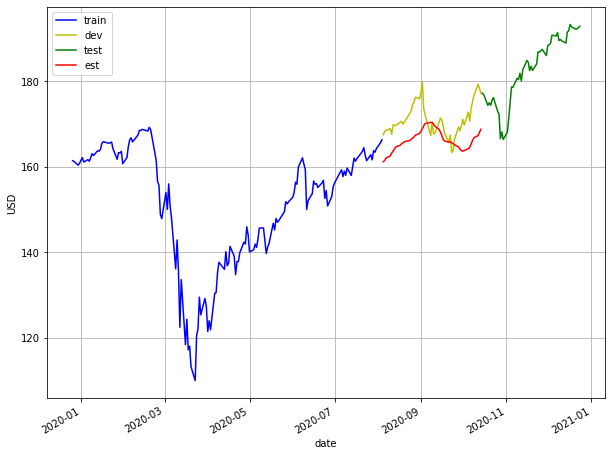

In [26]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est_inv': est_inv.reshape(-1), 
                       'y_cv_inv': y_cv_inv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Настройка N (количество дней для использования в качестве функций)

In [27]:
param_label = 'N'
param_list = range(1, 30)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
    
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, param, num_train)
    
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv_scaled,
                                          scaler,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer='adam',
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 5.465148258209228


,N,rmse,mape_pct
0,1,55.828090,32.539113
1,2,48.337129,28.158559
2,3,39.482084,22.977059
3,4,38.266781,22.259805
4,5,20.488316,11.809152
5,6,13.934053,7.884532
6,7,16.565783,9.449015
7,8,10.898311,6.006662
8,9,9.947917,5.394185
9,10,7.223161,3.711692


Text(0, 0.5, 'RMSE/MAPE(%)')

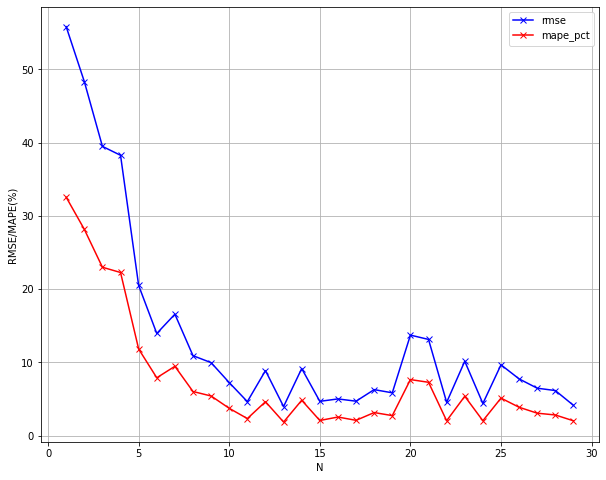

In [28]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [29]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 3.952
min MAPE = 1.839%
optimum N = 13


# Tuning model - epochs and batch_size

In [30]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
    
    for param2 in notebook.tqdm(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv_scaled,
                                              scaler,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer='adam',
                                              epochs=param,
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   



Minutes taken = 5.9221686283747355


,epochs,batch_size,rmse,mape_pct
0,1,8,3.978828,1.832400
1,1,16,7.278247,3.682738
2,1,32,22.817714,13.127006
3,1,64,35.689140,20.722323
4,1,128,51.805043,30.180119
5,10,8,7.402613,3.812948
6,10,16,10.050474,5.446300
7,10,32,11.349399,6.238766
8,10,64,15.504167,8.780603
9,10,128,9.257952,4.900482


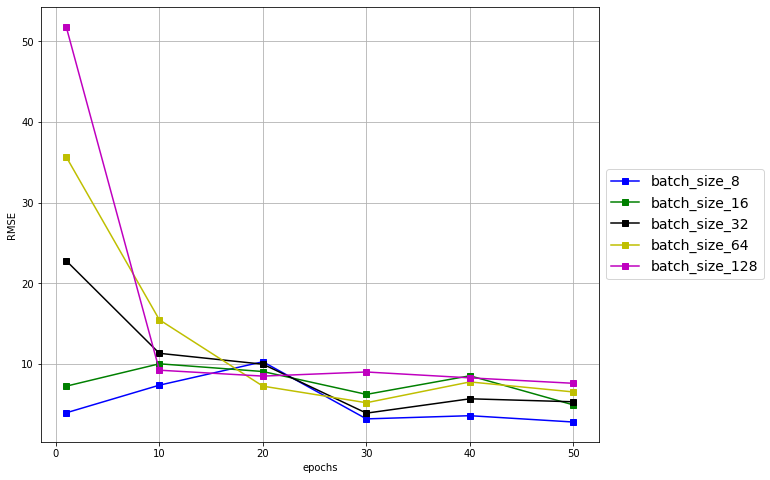

In [31]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [32]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 2.838
min MAPE = 1.351%
optimum epochs = 50
optimum batch_size = 8


# Tuning model - LSTM units and dropout prob

In [34]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
    
    for param2 in notebook.tqdm(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv_scaled,
                                              scaler,
                                              lstm_units=param,
                                              dropout_prob=param2,
                                              optimizer='adam',
                                              epochs=epochs_opt,
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   



Minutes taken = 7.533711127440134


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,7.563425,3.970450
1,10,0.6,8.140768,4.207921
2,10,0.7,10.663039,5.795027
3,10,0.8,12.885772,7.224762
4,10,0.9,21.691967,12.467633
5,50,0.5,4.260682,2.214370
6,50,0.6,3.667710,1.895988
7,50,0.7,3.281222,1.632272
8,50,0.8,6.939055,3.630844
9,50,0.9,8.583314,4.562541


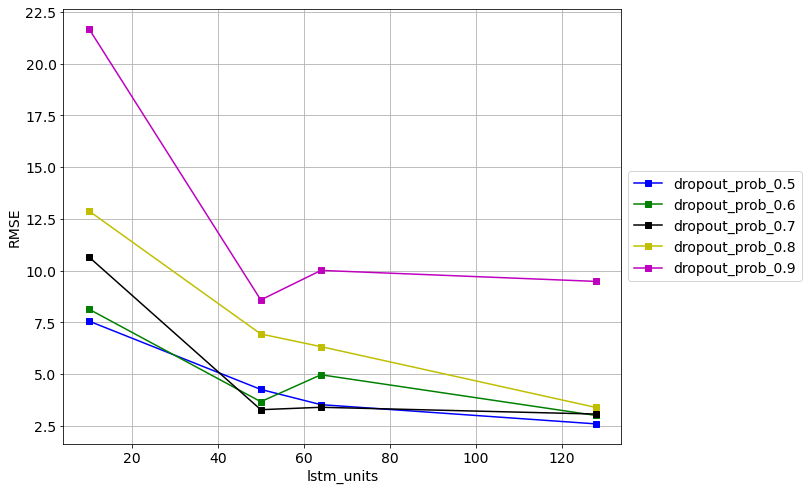

In [35]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [36]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 2.595
min MAPE = 1.146%
optimum lstm_units = 128
optimum dropout_prob = 0.5


# Tuning model - optimizer

In [37]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv_scaled,
                                              scaler,
                                              lstm_units=lstm_units_opt,
                                              dropout_prob=dropout_prob_opt,
                                              optimizer=param,
                                              epochs=epochs_opt,
                                              batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 3.4668959379196167


,optimizer,rmse,mape_pct
0,adam,2.580824,1.152970
1,sgd,5.708266,2.876272
2,rmsprop,2.630839,1.303268
3,adagrad,10.337342,5.609503
4,adadelta,45.091748,26.242529
5,adamax,3.152994,1.358086
6,nadam,2.533408,1.135302


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (7).

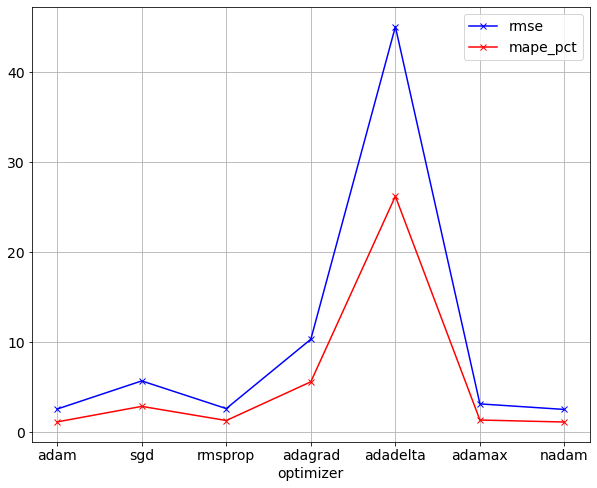

In [38]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [39]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 2.533
min MAPE = 1.135%
optimum optimizer = nadam


# Tuned params

In [40]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,13
1,lstm_units,50,128
2,dropout_prob,0.5,0.5
3,optimizer,adam,nadam
4,epochs,1,50
5,batch_size,10,8
6,rmse,6.16255,2.53341
7,mape_pct,3.15243,1.1353


# Финальная модель

In [41]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test_scaled = get_x_y(test_scaled, N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled,
                                        y_train_cv_scaled,
                                        x_test_scaled,
                                        y_test_scaled,
                                        scaler_final,
                                        lstm_units=lstm_units_opt,
                                        dropout_prob=dropout_prob_opt,
                                        optimizer=optimizer_opt,
                                        epochs=epochs_opt,
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 3.431
MAPE on test set = 1.480%


Text(0, 0.5, 'USD')

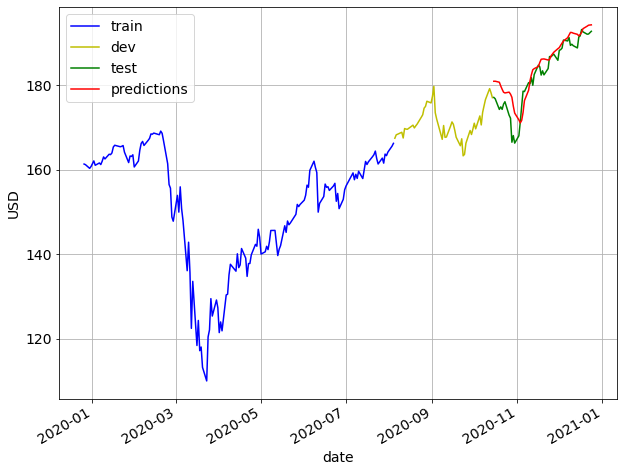

In [42]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': data[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

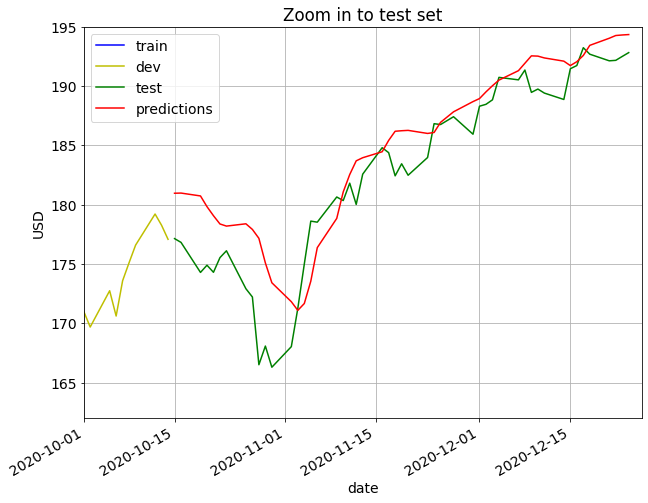

In [45]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 10, 1), date(2020, 12, 26)])
ax.set_ylim([162, 195])
ax.set_title("Zoom in to test set")